# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [1]:
#Importing libraries

import pandas as pd
import numpy as np
import math
import json

from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline

import seaborn as sns

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [2]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

# Data Understanding and exploration

We will explore the datasets by checking miising values, vusualizing etc so we can have a better understanding of how the dataset looks and how we can featurize the data t o make it ready for modelling

## Portfolio Dataset

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


* There is no missiing values in the data

In [5]:
portfolio.id.nunique()

10

In [6]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

* There are 3 types of offers(BOGO, Discount and Informational) with 10 different unique offers.

## Profile Dataset

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [10]:
nulls = profile[profile.gender.isnull()]
nulls

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [11]:
nulls.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [12]:
nulls.age.nunique()

1

we can see that the rows with nulls in gender and income all have age as 118. We can discard these rows later as they seem an outlier.

In [13]:
# Convert to datetime
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')


In [14]:
# Remove outliers (age 118)

profile = profile[profile.age < 118].reset_index(drop=True)

In [15]:
# store 0 and 1s in new columns
profile['missing'] = profile['age'].apply(lambda val: 1 if pd.isna(val) else 0)
dropped = profile[profile['missing'] == 1].index
# cleaned Dataset
clean_profile = profile.drop(dropped)
clean_profile.head()

,age,became_member_on,gender,id,income,missing
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,0
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0


In [16]:
## checking the gender
clean_profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

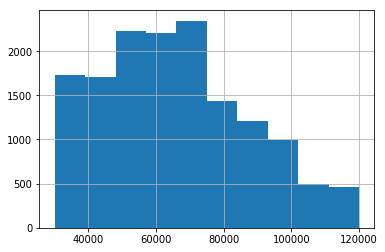

In [17]:
## income distribution
clean_profile.income.hist();

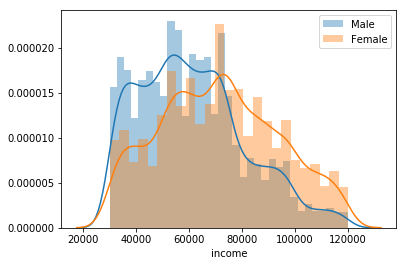

In [18]:
#Income distribution genderwise
sns.distplot(clean_profile[clean_profile.gender=='M'].income,label='Male')
sns.distplot(clean_profile[clean_profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

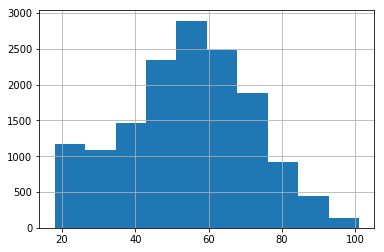

In [19]:
#age distribution
clean_profile.age.hist();

The age distribution was a normal distribution with highest numbers of customers between 50 and 60 years.

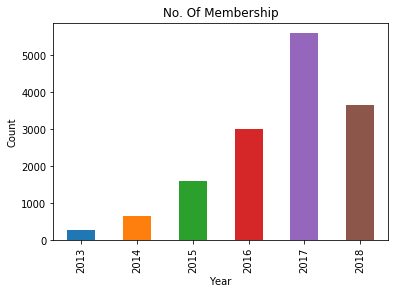

In [20]:
clean_profile['membership_year'] = profile['became_member_on'].dt.year
clean_profile['membership_year'].count()

mem_plot = clean_profile.groupby('membership_year').count()['id']
mem_plot.plot(kind = 'bar')
plt.title('No. Of Membership')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

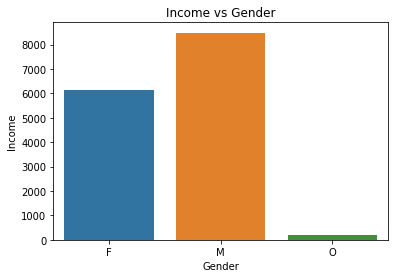

In [21]:
sns.countplot(x=clean_profile[clean_profile['gender'] != 'NA']['gender'])
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

Majority of customers were male with them also having higher income distribution

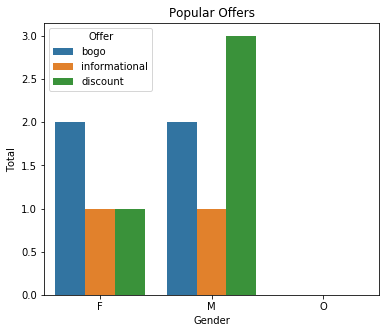

In [22]:
plt.figure(figsize=(6, 5))
sns.countplot(x=clean_profile.gender, hue=portfolio.offer_type)
plt.title('Popular Offers')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();

The most popular offer among both genders was the BOGO but the discount was more popular among the men.

In [23]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


## Transcript Dataset

In [24]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [25]:
## checking for nulls
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [26]:
#event distribution
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [27]:
df1 = transcript[transcript.event == 'transaction']
df2 = transcript[transcript.event == 'offer received']
df3 = transcript[transcript.event == 'offer viewed']
df4 = transcript[transcript.event == 'offer completed']

df1['amount'] = df1.value.apply(lambda x:list(x.values())[0])
df2['offer_id'] = df2.value.apply(lambda x:list(x.values())[0])
df3['offer_id'] = df3.value.apply(lambda x:list(x.values())[0])
df4['offer_id'] = df4.value.apply(lambda x:list(x.values())[0])
df4['reward'] = df4.value.apply(lambda x:list(x.values())[1])

transcript = pd.concat([df1,df2,df3,df4])
transcript = transcript[['event' , 'person' , 'offer_id' ,'time', 'amount' , 'reward' , 'value']]
transcript.drop(columns='value' , inplace=True)

transcript.head()

,event,person,offer_id,time,amount,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN


the offer id column is duplicated hence we need to clean it to ensure theres only one offer id column

In [28]:
transcript.head()

,event,person,offer_id,time,amount,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN


In [29]:
transcript.offer_id.nunique()

10

In [30]:
transcript.person.nunique()

17000

The number of people in the transcript data set are same as in the portfolio dataset

## Data Preparation

In [31]:
transcript = pd.get_dummies(transcript , columns=['event'] , prefix='' ,prefix_sep='')
transcript.drop_duplicates(inplace=True)
transcript.duplicated().sum()

0

In [32]:
merged = pd.merge(transcript , profile ,left_on='person' , right_on='id',how='inner')
merged.drop(columns=['id'] , inplace=True)
# Fill nans with 0
merged.reward.fillna(0 , inplace=True)
merged.amount.fillna(0 , inplace=True)

# sort values
merged.sort_values(by=['time'] , ascending=True , inplace=True)

list1 = ['transaction', 'amount']

for i in list1:
    merged[i] = merged.groupby('person')[i].cumsum()

In [33]:
merged.dropna(subset=['offer_id'] ,inplace=True)
merged = merged.merge(portfolio , left_on='offer_id' , right_on='id'  ,how='left')
Model_data = merged.groupby(['person' , 'offer_type']).agg(
    {
         'offer completed':sum,   
         'offer received': sum, 
         'offer viewed': sum,  
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last'
    }
).reset_index()


In [34]:
def offers_transformation(df):
    '''
    Function: to transform the ofers
    
    Returns: The transformed offers
    '''
    
    df['bogo_received'] = 0
    df['bogo_completed'] = 0

    df['discount_received'] = 0
    df['discount_completed'] = 0

    for index , row in df.iterrows():
        if(row['offer_type'] == 'bogo'):
            df.loc[index , 'bogo_completed'] = row['offer completed']
            df.loc[index , 'bogo_received'] = row['offer received']

        elif(row['offer_type'] == 'discount'):
            df.loc[index , 'discount_completed'] = row['offer completed']
            df.loc[index , 'discount_received'] = row['offer received']
        
        
        
    return df.groupby(['person']).agg(
    {
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last', 
        'bogo_received':sum,
        'bogo_completed':sum,
        'discount_received':sum,
        'discount_completed':sum, 
    }
).reset_index()

In [35]:
trans_data = offers_transformation(Model_data)
trans_data.head()


,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2
1,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2
2,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2
3,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1
4,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,F,73000.0,0,0,3,3


In [36]:
# create colunms with the precnetage of each offer
trans_data['bogo_perce'] = trans_data.bogo_completed.div(trans_data.bogo_received.where(trans_data.bogo_received != 0, np.nan))*100
trans_data['discount_perce'] = trans_data.discount_completed.div(trans_data.discount_received.where(trans_data.discount_received != 0, np.nan))*100

trans_data.fillna(0 , inplace=True)

trans_data.isna().sum()

person                0
age                   0
became_member_on      0
gender                0
income                0
bogo_received         0
bogo_completed        0
discount_received     0
discount_completed    0
bogo_perce            0
discount_perce        0
dtype: int64

In [37]:
trans_data['bogo_offer'] = 0
trans_data['discount_offer'] = 0


for i ,row in trans_data.iterrows():

    if(row['bogo_perce'] >= 80):
        trans_data.loc[i , 'bogo_offer'] = 1
        
    if(row['discount_perce'] >= 80 ):
        trans_data.loc[i , 'discount_offer'] = 1

## Data Modelling

In [38]:
Model_data2 = trans_data.copy()
Model_data2['year'] = Model_data2.became_member_on.dt.year
Model_data2['month'] = Model_data2.became_member_on.dt.month

In [39]:
Model_data2 = Model_data2[['age' , 'gender' , 'income' ,
                           'year' , 'month' , 'discount_offer' ,
                           'bogo_offer']]

In [40]:
Model_data3 = pd.get_dummies(Model_data2 , columns=['gender'])

In [41]:
X = Model_data3.drop(columns=['discount_offer' ,'bogo_offer'])
y_bogo = Model_data3.bogo_offer
y_discount = Model_data3.discount_offer

In [42]:
## splitting into train and test
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(X, y_bogo, random_state=42)
X_train, X_test, y_discount_train, y_discount_test = train_test_split(X, y_discount, random_state=42)


### KNeighboursClassifier Model

In [43]:
model1_bogo = KNeighborsClassifier()
model1_discount = KNeighborsClassifier()
model1_bogo.fit(X_train, y_bogo_train)
model1_discount.fit(X_train, y_discount_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [44]:
print('Bogo offer F1_score {}'.format( model1_bogo.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(model1_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model1_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model1_discount.score(X_test,y_discount_test)))


Bogo offer F1_score 0.6022492127755286
Bogo offe Test F1_score 0.545748987854251
Discount offer Training F1_score 0.714260008996851
Discount offer Test F1_score 0.5430499325236168


### GaussianNB Model

In [45]:
model2_bogo = GaussianNB()
model2_discount = GaussianNB()
model2_bogo.fit(X_train, y_bogo_train)
model2_discount.fit(X_train, y_discount_train)

GaussianNB(priors=None)

In [46]:
print('Bogo offer F1_score {}'.format( model2_bogo.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(model2_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model2_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model2_discount.score(X_test,y_discount_test)))


Bogo offer F1_score 0.6021592442645074
Bogo offe Test F1_score 0.5951417004048583
Discount offer Training F1_score 0.6209626630679262
Discount offer Test F1_score 0.6072874493927125


### SVC Model

In [47]:
model3_bogo = SVC()
model3_discount = SVC()
model3_bogo.fit(X_train, y_bogo_train)
model3_discount.fit(X_train, y_discount_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [48]:
print('Bogo offer F1_score {}'.format( model3_bogo.score(X_train,y_discount_train)))
print('Bogo offer Test F1_score {}'.format(model3_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model3_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model3_discount.score(X_test,y_discount_test)))


Bogo offer F1_score 0.6342780026990553
Bogo offer Test F1_score 0.551417004048583
Discount offer Training F1_score 0.8960863697705803
Discount offer Test F1_score 0.5460188933873145


### AdaBoost Classifier Model


In [49]:
model4_bogo = AdaBoostClassifier()
model4_discount = AdaBoostClassifier()
model4_bogo.fit(X_train, y_bogo_train)
model4_discount.fit(X_train, y_discount_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [50]:
print('Bogo offer F1_score {}'.format( model4_bogo.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(model4_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model4_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model4_discount.score(X_test,y_discount_test)))


Bogo offer F1_score 0.6379667116509222
Bogo offe Test F1_score 0.6412955465587045
Discount offer Training F1_score 0.656140350877193
Discount offer Test F1_score 0.6510121457489878


In [51]:
def get_predict(customer , offer):
    '''
    Function: to get the prediction
    
    Input: customer, offer
    
    output: prediction
    
    '''
    predict_bogo = 0
    predict_discount = 0 
    

    predict_bogo = model4_bogo.predict(customer.values)[0]
    predict_discount = model4_discount.predict(customer.values)[0]
    
    if(predict_bogo == 0 & predict_discount == 0):
        print('No Response!')

        
    if (offer == 'bogo'):
        if(predict_bogo == 0):
            if(predict_discountt == 1):
                print('preferred discount')           
        else:
            print('Bogo choice')
    if (offer == 'discount'):
        if(predict_discount == 0):
            if(predict_bogo == 1):
                print('preferred bogo')           
        else:
            print('Discount choice')

In [52]:
get_predict(X_test[1:3] ,'bogo')

Bogo choice


## Conclussions

* The best performing F1 score was 0.89 by SVC for the discount offer training.
* The lowest of all models was the KNeighboursClassifier Model for BOGO training.
* More promotions should be focused on males as they are the higher income earners with the discount offers being the best for them.

The most interesting part was the cleaning and data preparation as it helped understand the data more and improve my skills in python.

The models could be improved further by using grid search 
